In [1]:
# importing pandas 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

### Equations that will be helpful later,

In [217]:
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

In [214]:
def taperedPower_law(x, D, E, G):
    return D*np.power(x, E) * np.exp(x * G)

In [192]:
def gaussian(x, A, B, C):
    return A * np.exp(-(x-B)**2/(2*C**2))

In [193]:
def taperedPowerLaw_plusGaussian(x, A, B, C, D, E, G):
#     A, B, C, D, E, G = theta
    gaus = A * np.exp(-(x-B)**2/(2*C**2))
    powerLaw = D*np.power(x, E)
    taper = np.exp(-x * G)
    
    return powerLaw * taper + gaus

### Read in data from txt file

In [2]:
file = "GWLup.profile.txt"
  
# read text file into pandas DataFrame 
df = pd.read_csv(file, header=None, sep='\s+') 
  
# display DataFrame 
df

,0,1,2,3,4,5,6,7
0,0.5,0.003226,3.280600e-03,7.936900e-05,36.906000,0.892880,4.2382E+01,8.9834E-01
1,1.5,0.009677,3.117800e-03,1.130800e-04,35.074000,1.272100,4.0539E+01,1.2806E+00
2,2.5,0.016129,2.832100e-03,1.330000e-04,31.860000,1.496200,3.7302E+01,1.5081E+00
3,3.5,0.022581,2.480300e-03,1.246900e-04,27.903000,1.402700,3.3309E+01,1.4167E+00
4,4.5,0.029032,2.116900e-03,1.076300e-04,23.815000,1.210800,2.9174E+01,1.2265E+00
...,...,...,...,...,...,...,...,...
295,295.5,1.906500,-1.847500e-07,1.024200e-06,-0.002078,0.011522,NAN,NAN
296,296.5,1.912900,-1.740300e-08,1.004000e-06,-0.000196,0.011295,NAN,NAN
297,297.5,1.919400,-6.854500e-08,9.849400e-07,-0.000771,0.011080,NAN,NAN
298,298.5,1.925800,-1.514800e-07,9.705500e-07,-0.001704,0.010918,NAN,NAN


In [3]:
# Collect the data into arrays
radius_au = np.array(df[0])                         #AU
radius_arcsec = np.array(df[1])                     #arcseconds
surfaceBrightness = np.array(df[2])                 #Jy/beam
sigma_surfaceBrightness = np.array(df[3])           #Jy/beam
brightnessTemperature = np.array(df[4])             #K (Calculated using Rayleigh-Jeans approximation)
sigma_brightnessTemperature = np.array(df[5])       #K
fullBrightnessTemperature = np.array(df[6])         #K (Calculated using the full Planck Eqn)
sigma_fullBrightnessTemperature = np.array(df[7])   #K


### Plot the azimuthally-averaged radial intensity profile: visualizing the data

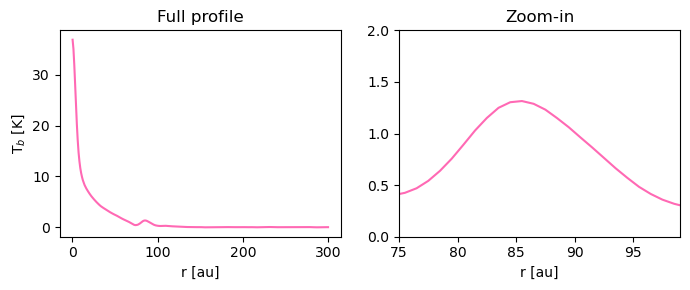

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3))

ax1.plot(radius_au, brightnessTemperature, color='hotpink')
ax1.set(xlabel='r [au]', ylabel='T$_b$ [K]', title='Full profile')

ax2.plot(radius_au, brightnessTemperature, color='hotpink')
ax2.set(xlabel='r [au]', title='Zoom-in')
ax2.set(xlim=(75,99), ylim=(0,2))

# plt.suptitle(file[:5])
plt.tight_layout()
plt.savefig('TemperatureProfile.png', dpi=300);


I went through all the images and these are my fav:
- AS209 (two outer rings)
- GW Lup (one ring)
- HD143006 (multiple rings and asymmetries)
- AS 205_N (one really wide ring)
- DoAr25 (oneish ring)
- HD163296 (two rings and asymmetry)

### Gaussian:

$$
f(x) = a e^{-\frac{(x-b)^2}{2c^2}}
$$

- a: height of curve
- b: center of curve
- c: standard deviation

### Making an initial guess

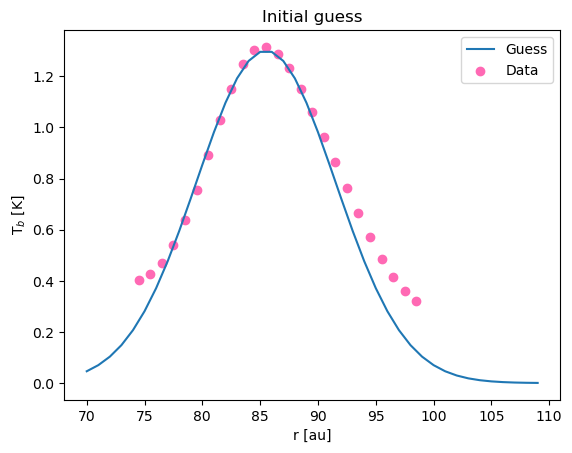

In [194]:
# Visualizing the data and making an initial guess
a_true = 1.3
b_true = 85.5
c_true = 6.0

x0 = np.arange(70, 110)

gaus = a_true * np.exp(-(x0-b_true)**2/(2*c_true**2))
plt.plot(x0, gaus, label='Guess')
plt.scatter(radius_au[74:99], brightnessTemperature[74:99], color='hotpink', label='Data')

# plt.ylim(0,2)
# plt.xlim(70,100)
plt.legend()
plt.xlabel('r [au]')
plt.ylabel('T$_b$ [K]')
plt.title('Initial guess');

### Log-likelihood function:

In [263]:
# Define a Gaussian log likelihood function
def Gaussianlog_likelihood(theta, x, y, yerr):
    a, b, c, log_f = theta
    model = a * np.exp(-(x-b)**2/(2*c**2)) #gaussian function
#     model = gaussian(x, a, b, c)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f) #likelihood function
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


### Maximum likelihood estimation:


In [264]:
from scipy.optimize import minimize
# Choose some "true" parameters from my best guess
a_true = 1.3
b_true = 85.5
c_true = 6.0
f_true = 0.5

# Data
x = radius_au[75:99]
y = brightnessTemperature[75:99]
yerr = 0.0

np.random.seed(42)
nll = lambda *args: -Gaussianlog_likelihood(*args)
initial = np.array([a_true, b_true, c_true, np.log(f_true)]) + 0.1 * np.random.randn(4) #Initial guesses
soln = minimize(nll, initial, args=(x, y, yerr))  #Result of maximum likelihood estimation
a_ml, b_ml, c_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("b = {0:.3f}".format(b_ml))
print("c = {0:.3f}".format(c_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))


Maximum likelihood estimates:
a = 1.222
b = 86.144
c = 7.146
f = 0.069


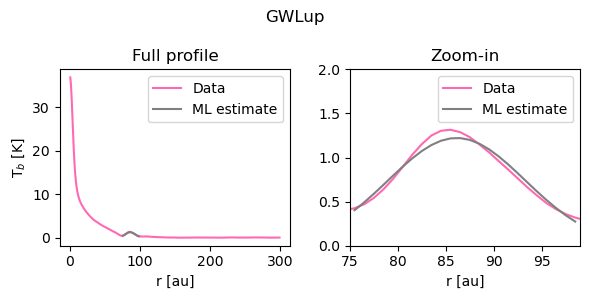

In [265]:
model_ml = a_ml * np.exp(-(x-b_ml)**2/(2*c_ml**2))

# plt.scatter(radius_au, brightnessTemperature, color='hotpink', marker='+')
# plt.plot(x, model, label='ML estimate', color='grey', linewidth=3)

# plt.legend();

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))

ax1.plot(radius_au, brightnessTemperature, color='hotpink', label='Data')
ax1.plot(x, model_ml, label='ML estimate', color='grey')
ax1.set(xlabel='r [au]', ylabel='T$_b$ [K]', title='Full profile')
ax1.legend()

ax2.plot(radius_au, brightnessTemperature, color='hotpink', label='Data')
ax2.set(xlabel='r [au]', title='Zoom-in')
ax2.plot(x, model_ml, label='ML estimate', color='grey')
ax2.set(xlim=(75,99), ylim=(0,2))
ax2.legend()

plt.suptitle(file[:5])
plt.tight_layout();

### Fitting the Background: 

**Tapered Power-Law Background:**
$$
f(r) = Dr^E * e^{-Gr}
$$

So the final equation will be the sum of these two
$$
f(r) = Dr^E * e^{Gr} + A * e^{-\frac{(r-B)^2}{2C^2}}
$$
$$
f(x) = Dx^E * e^{Gx} + A * e^{-\frac{(x-B)^2}{2C^2}}
$$
Therefore, there are 6 different parameters to fit.


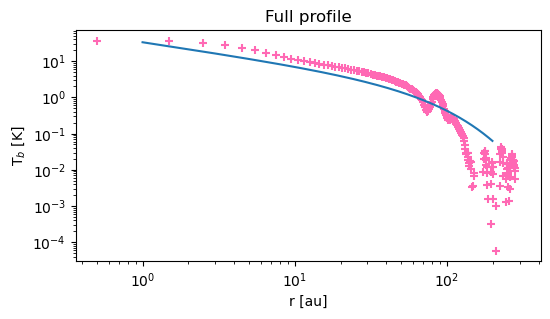

In [266]:
fig, ax1 = plt.subplots(1,1, figsize=(6,3))

x = np.arange(1,200)

# Choose some "true" parameters from my best guess
# Power-law parameters
d_true = 33.78571529
e_true = -0.62413465
# Exponential taper parameters
g_true = 0.015


model = d_true*x**e_true * np.exp(-x*g_true)


ax1.plot(x, model)

ax1.scatter(radius_au, brightnessTemperature, color='hotpink', marker = '+')
ax1.set(xlabel='r [au]', ylabel='T$_b$ [K]', title='Full profile')
# ax1.set(ylim=(-1,50));
ax1.set(yscale='log', xscale='log');

### Log-likelihood function:


In [268]:
# Define a tapered power-law + gaussian log likelihood function
def Backgroundlog_likelihood(theta, x, y, yerr):
    d, e, g, log_f = theta    
    model = d * x**e * np.exp(x*g)
#     model = taperedPower_law(x, d, e, g)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f) #likelihood function
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

### Maximum likelihood estimation


In [269]:
from scipy.optimize import minimize
# Choose some "true" parameters from my best guess
# Power-law parameters
d_true = 33.78571529
e_true = -0.62413465
# Exponential taper parameters
g_true = -0.015
f2_true = 0.0

# Data
x = radius_au
y = brightnessTemperature
yerr = 0.0

np.random.seed(42)
nll = lambda *args: -Backgroundlog_likelihood(*args)
initial = np.array([d_true, e_true, g_true, np.log(f_true)]) + 0.1 * np.random.randn(4) #Initial guesses
soln = minimize(nll, initial, args=(x, y, yerr))  #Result of maximum likelihood estimation
d_ml, e_ml, g_ml, log_f2_ml = soln.x

print("Maximum likelihood estimates:")
print("d = {0:.3f}".format(d_ml))
print("e = {0:.3f}".format(e_ml))
print("g = {0:.3f}".format(g_ml))
print("f2 = {0:.3f}".format(np.exp(log_f2_ml)))

Maximum likelihood estimates:
d = 141.699
e = -1.177
g = -0.012
f2 = 1.621


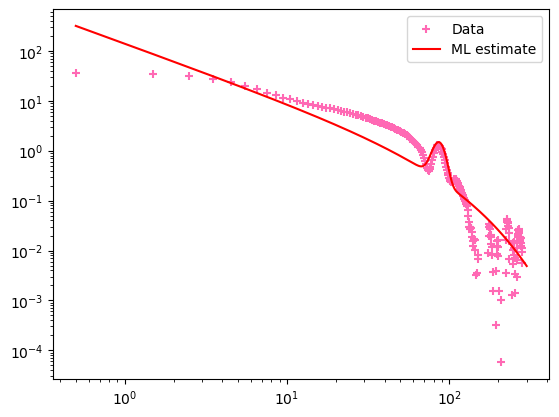

In [270]:
model_ml = d_ml * x**e_ml * np.exp(x*g_ml)
model_combine = d_ml * x**e_ml * np.exp(x*g_ml) + a_ml * np.exp(-(x-b_ml)**2/(2*c_ml**2))

plt.scatter(radius_au, brightnessTemperature, color='hotpink', marker='+', label='Data')
# plt.plot(x, model_ml, label='ML estimate', color='grey')
plt.plot(x, model_combine, label='ML estimate', color='red')

# plt.ylim(0,30)
plt.legend()
plt.xscale('log')
plt.yscale('log');

In [271]:
# Free parameters:

# params = [a_ml, b_ml, c_ml, log_f_ml, d_ml, e_ml, g_ml, log_f2_ml]
params = [a_ml, b_ml, c_ml, d_ml, e_ml, g_ml, log_f_ml]

print(params)

[1.2219532124063393, 86.14373792545724, 7.146141876213397, 141.69871223160408, -1.1773106689351616, -0.011890030051323315, -2.680230179141666]


## Creating the "skeleton" of my MCMC

$$
I_{\nu}^{gauss}(r) = A * exp(-\frac{(r - r_0)^2}{2\sigma^2})
$$

### Log-likelihood function:

In [279]:
# Define a tapered power-law + gaussian log likelihood function
def log_likelihood(theta, x, y, yerr):
    a, b, c, d, e, g, log_f = theta    
    model = d*x**e* np.exp(x*g) + (a * np.exp(-(x-b)**2/(2*c*2))) #tapered power-law + gaussian 
#     model = taperedPower_law(x, d, e, g) + gaussian(x, a, b, c)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f) #likelihood function
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


### Log-prior function:
Double check that inital guesses fall within priors

In [280]:
# Define a log-prior function
def log_prior(theta):
    a, b, c, d, e, g, log_f = theta
    if 0.0 < a < 10.0 and 75.0 < b < 95.0 and 0.0 < c < 20.0 and -10.0 < log_f < 10.0 and 0.0 < d < 300.0 and -5.0 < e < 0.0 and -5.0 < g < 0.0:
        return 0.0
    return -np.inf

### Posterior-probability function:

In [281]:
# Combine log-likelihood function and log-prior function
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

## Running the MCMC

In [178]:
len(params)


7

In [179]:
params

[1.2219532124063393,
 86.14373792545724,
 7.146141876213397,
 141.69871223160408,
 -1.1773106689351616,
 -0.011890030051323315,
 -2.680230179141666]

In [282]:
x = radius_au
y = brightnessTemperature
yerr = 0

In [303]:
import emcee
dim = len(params)

soln = np.array(params)

pos = soln + 1e-4 * np.random.randn(32, dim)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 50000, progress=True);

100%|████████████████████████████████████| 50000/50000 [00:54<00:00, 914.47it/s]


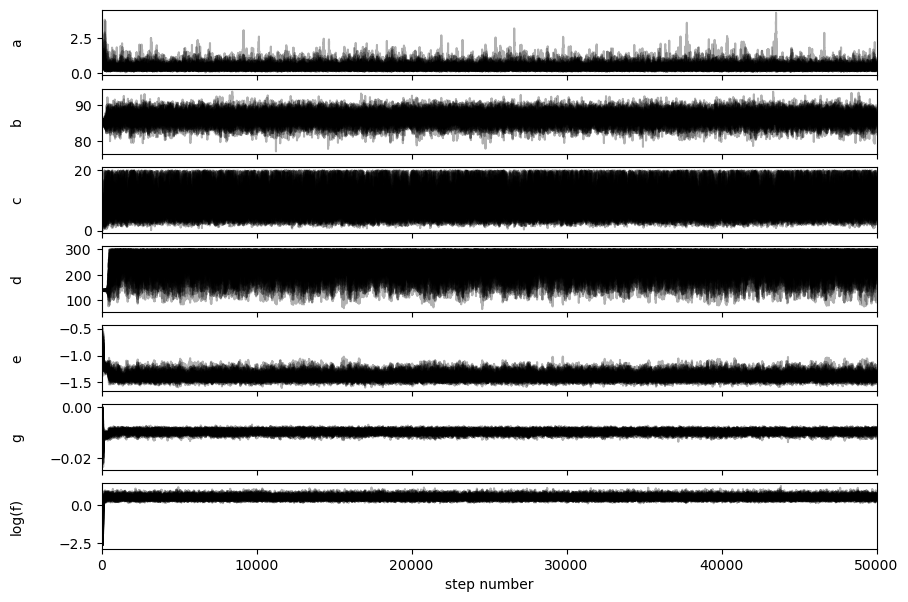

In [304]:
fig, axes = plt.subplots(dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a","b","c","d", "e", "g", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [305]:
tau = sampler.get_autocorr_time()
print(tau)

[154.27258805 120.75415744 135.31379314 190.85641083 195.80556937
 123.09698735 113.49251441]


In [306]:
# Apply "burn-in", thin, and flatten th chain
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
print(flat_samples.shape)

(106240, 7)


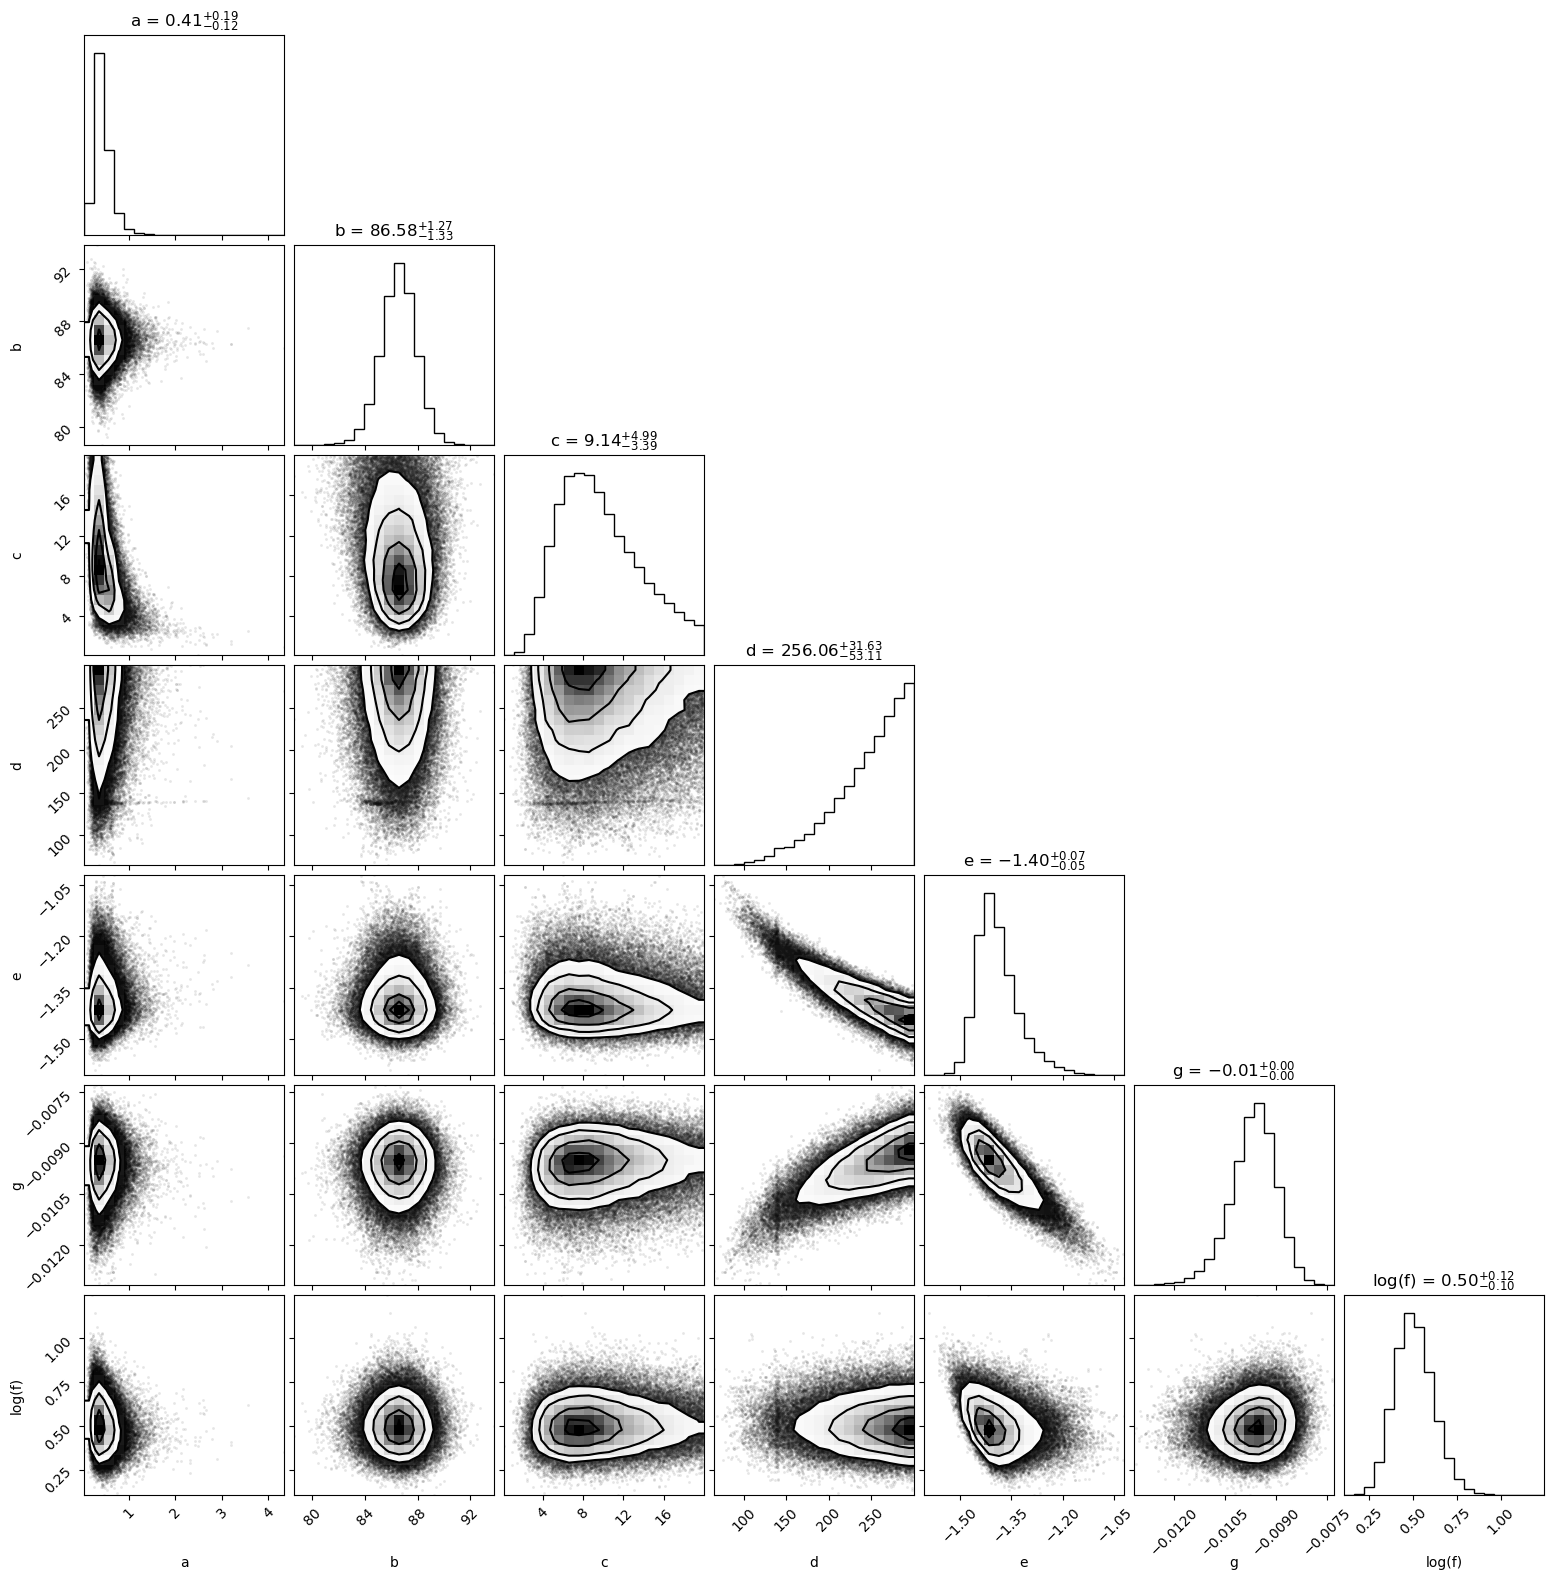

In [307]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True
);

In [308]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

soln_mcmc = []
q_low = []
q_high = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    soln_mcmc.append(mcmc[1])
    q_low.append(q[0])
    q_high.append(q[1])
        

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [289]:
soln_mcmc, q_low

([0.4071799685516223,
  86.5628679407404,
  9.185249819420058,
  255.5187967661419,
  -1.3989946330452268,
  -0.009612546145933012,
  0.5003750260324455],
 [0.12121095024201944,
  1.3259356712035384,
  3.408284079688973,
  53.03309010998433,
  0.04646367198806867,
  0.0006858663638800635,
  0.1040186683782307])

In [255]:
tab_mcmc = pd.DataFrame([soln_mcmc, q_low, q_high], columns=['a', 'b','c','d','e','g','log(f)'])
tab_mcmc

,a,b,c,d,e,g,log(f)
0,0.395219,86.346160,4.311497,257.445103,-1.403684,-0.009546,0.503130
1,0.131602,2.156862,1.009277,51.736169,0.049627,0.000702,0.105295
2,0.210654,1.363940,2.191059,30.858294,0.067408,0.000666,0.117942


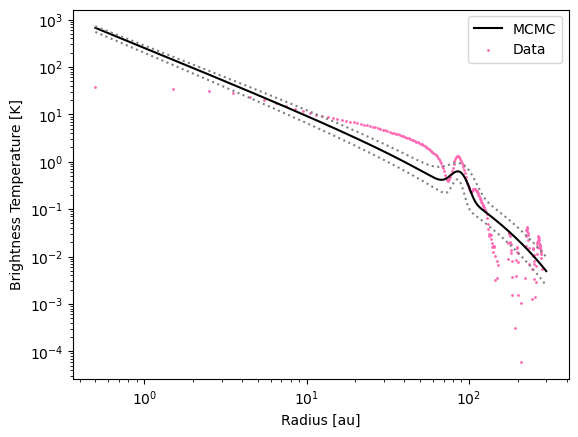

In [293]:
a,b,c,d,e,g,logf = soln_mcmc
a_low,b_low,c_low,d_low,e_low,g_low,logf_low = q_low
a_high,b_high,c_high,d_high,e_high,g_high,logf_high = q_high

model_ml = d_ml * x**e_ml * np.exp(x*g_ml) + a_ml * np.exp(-(x-b_ml)**2/(2*c_ml**2))
model_combine = d * x**e * np.exp(x*g) + a * np.exp(-(x-b)**2/(2*c**2))
lower = (d-d_low) * x**(e-e_low) * np.exp(x*(g-g_low)) + (a-a_low) * np.exp(-(x-(b-b_low))**2/(2*(c-c_low)**2))
upper = (d+d_high) * x**(e+e_high) * np.exp(x*(g+g_high)) + (a+a_high) * np.exp(-(x-(b+b_high))**2/(2*(c+c_high)**2))


# a,b,c,d,e,g,logf = q_low
# lower = d * x**e * np.exp(x*g) + a * np.exp(-(x-b)**2/(2*c**2))
# a,b,c,d,e,g,logf = q_high
# upper = d * x**e * np.exp(x*g) + a * np.exp(-(x-b)**2/(2*c**2))



plt.plot(x, model_combine, color='black', label='MCMC')
plt.plot(x, lower, color='grey', linestyle='dotted')
plt.plot(x, upper, color='grey', linestyle='dotted')
# plt.plot(x, model_ml, label='Maximum likelihood estimate', color='blue')



plt.scatter(x,y, color='hotpink', label='Data', s=1)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radius [au]')
plt.ylabel('Brightness Temperature [K]');
